# Shifting of Price Forwad Curves (PFCs) for Energy Markets

Toy model for the spot price for electricity:
$$
S(t) = S_0 + 
    \begin{cases}
    0 & ,0 \leq h(t) < 8\\
    P_p & ,8 \leq h(t) < 11\\
    -P_{pv} & ,11\leq h(t) < 16\\
    P_p & ,16 \leq h(t) \leq 20\\
    0 & ,20 < h(t) \leq 23
    \end{cases} +
    \begin{cases}
        0 & ,1\leq d(d) \leq 5\\
        -P_{we} & ,6\leq d(t) \leq 7
    \end{cases} +
    \begin{cases}
        0 & ,m(t) \in \{4,5,6,7,8,9\}\\
        P_{W} & ,m(t) \in \{1,2,3,10,11,12\}
    \end{cases} + \varepsilon
$$
The parameters here are:
$$
\begin{align*}
S_0 &\quad\text{Spot price level}\\
P_p & \quad\text{Peak price level}\\
P_{pv} & \quad\text{Price level with regard to solar power}\\
P_{we} & \quad\text{Price level for weekends}\\
P_W & \quad\text{Price level for winter}\\
h(t) & \quad\text{Hour of the time step $t$}\\
d(t) & \quad\text{Week day of the time step $t$}\\
m(t) & \quad\text{Month of the time step $t$}\\
\varepsilon&  \sim \mathcal{N}(\mu, \sigma^2)
\end{align*}
$$

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [33]:
def spot_price_model(timestamp: dt.datetime, spot_price_level: float, peak_price_level:float, solar_price_level: float,
                     weekend_price_level:float, winter_price_level: float, epsilon_mean: float = 0, epsilon_var:float = 1):
                    spot_price = spot_price_level
                    if (timestamp.hour >= 8 and timestamp.hour < 11) or (timestamp.hour >= 16 and timestamp.hour <= 20):
                            spot_price += peak_price_level
                    elif timestamp.hour >= 11 and timestamp.hour < 16:
                            spot_price -= solar_price_level
                    
                    if timestamp.weekday() >= 5:
                            spot_price -= weekend_price_level

                    if timestamp.month in {1,2,3,10,11,12}:
                            spot_price += winter_price_level 

                    spot_price += np.random.normal(loc=epsilon_mean, scale=np.sqrt(epsilon_var))
                    return spot_price

In [29]:
parameter_dict = {
    'spot_price_level': 100,
    'peak_price_level': 10,
    'solar_price_level': 8,
    'weekend_price_level': 10,
    'winter_price_level': 20,
    'epsilon_mean': 0,
    'epsilon_var': 2
}


In [34]:
date_range = pd.date_range(start='1/1/2020', end='1/1/2024', freq='H', inclusive='left')

In [35]:
spot_prices = list(map(lambda x: spot_price_model(x, **parameter_dict), date_range))

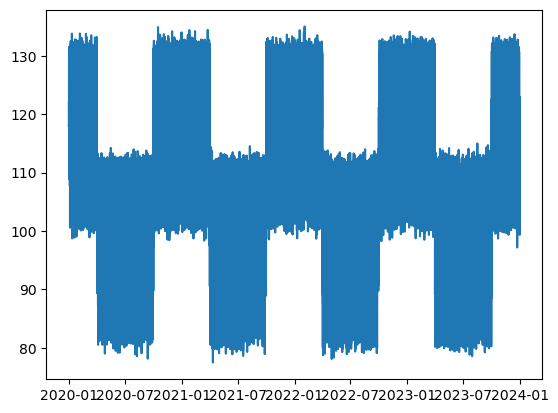

In [39]:
plt.plot(date_range, spot_prices)